### Vmax

The purpose of this notebook is to demonstrate how to estimate Vmax using the FastSpecFit model fitting results. For additional details please see the `tutorial-kcorrections.ipynb` notebook.

To load all the dependencies simply run (at NERSC):
```
source /dvs_ro/common/software/desi/desi_environment.sh main
module load fastspecfit/2.4.0
```

John Moustakas  
Siena College  
2023 August 19

#### Basic imports

In [1]:
import os
import numpy as np
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=0.8)

In [2]:
from fastspecfit.util import TabulatedDESI
from fastspecfit.continuum import ContinuumTools
from fastspecfit.io import read_fastspecfit, cache_templates
from fastspecfit._version import __version__
print(__version__)

2.4.0


#### Instantiate the cosmology and the continuum-fitting tools class, and load the templates.

In [3]:
cosmo = TabulatedDESI()
CTools = ContinuumTools()
templates = cache_templates()

#### Read fitting results for a single object.

As an initial simple example, let's fit a single galaxy. (Skip this section if you already have fitting results that you just want to read.)

In [4]:
fastfile = os.path.join(os.getenv('HOME'), 'fastspec-39633109787873428.fits')
fast, meta, _, _ = read_fastspecfit(fastfile, read_models=False)
fast

INFO:io.py:1798:read_fastspecfit: Read 1 object(s) from /global/homes/i/ioannis/fastspec-39633109787873428.fits


TARGETID,SURVEY,PROGRAM,HEALPIX,Z,COEFF,RCHI2,RCHI2_CONT,RCHI2_PHOT,SNR_B,SNR_R,SNR_Z,SMOOTHCORR_B,SMOOTHCORR_R,SMOOTHCORR_Z,VDISP,VDISP_IVAR,AV,AGE,ZZSUN,LOGMSTAR,SFR,DN4000,DN4000_OBS,DN4000_IVAR,DN4000_MODEL,FLUX_SYNTH_G,FLUX_SYNTH_R,FLUX_SYNTH_Z,FLUX_SYNTH_SPECMODEL_G,FLUX_SYNTH_SPECMODEL_R,FLUX_SYNTH_SPECMODEL_Z,FLUX_SYNTH_PHOTMODEL_G,FLUX_SYNTH_PHOTMODEL_R,FLUX_SYNTH_PHOTMODEL_Z,FLUX_SYNTH_PHOTMODEL_W1,FLUX_SYNTH_PHOTMODEL_W2,FLUX_SYNTH_PHOTMODEL_W3,FLUX_SYNTH_PHOTMODEL_W4,ABSMAG10_DECAM_G,ABSMAG10_IVAR_DECAM_G,KCORR10_DECAM_G,ABSMAG10_DECAM_R,ABSMAG10_IVAR_DECAM_R,KCORR10_DECAM_R,ABSMAG10_DECAM_Z,ABSMAG10_IVAR_DECAM_Z,KCORR10_DECAM_Z,ABSMAG00_U,ABSMAG00_IVAR_U,KCORR00_U,ABSMAG00_B,ABSMAG00_IVAR_B,KCORR00_B,ABSMAG00_V,ABSMAG00_IVAR_V,KCORR00_V,ABSMAG01_SDSS_U,ABSMAG01_IVAR_SDSS_U,KCORR01_SDSS_U,ABSMAG01_SDSS_G,ABSMAG01_IVAR_SDSS_G,KCORR01_SDSS_G,ABSMAG01_SDSS_R,ABSMAG01_IVAR_SDSS_R,KCORR01_SDSS_R,ABSMAG01_SDSS_I,ABSMAG01_IVAR_SDSS_I,KCORR01_SDSS_I,ABSMAG01_SDSS_Z,ABSMAG01_IVAR_SDSS_Z,KCORR01_SDSS_Z,ABSMAG01_W1,ABSMAG01_IVAR_W1,KCORR01_W1,LOGLNU_1500,LOGLNU_2800,LOGL_1450,LOGL_1700,LOGL_3000,LOGL_5100,FLYA_1215_CONT,FOII_3727_CONT,FHBETA_CONT,FOIII_5007_CONT,FHALPHA_CONT,RCHI2_LINE,DELTA_LINECHI2,DELTA_LINENDOF,APERCORR,APERCORR_G,APERCORR_R,APERCORR_Z,NARROW_Z,NARROW_ZRMS,BROAD_Z,BROAD_ZRMS,UV_Z,UV_ZRMS,NARROW_SIGMA,NARROW_SIGMARMS,BROAD_SIGMA,BROAD_SIGMARMS,UV_SIGMA,UV_SIGMARMS,MGII_DOUBLET_RATIO,OII_DOUBLET_RATIO,SII_DOUBLET_RATIO,LYALPHA_MODELAMP,LYALPHA_AMP,LYALPHA_AMP_IVAR,LYALPHA_FLUX,LYALPHA_FLUX_IVAR,LYALPHA_BOXFLUX,LYALPHA_BOXFLUX_IVAR,LYALPHA_VSHIFT,LYALPHA_SIGMA,LYALPHA_CONT,LYALPHA_CONT_IVAR,LYALPHA_EW,LYALPHA_EW_IVAR,LYALPHA_FLUX_LIMIT,LYALPHA_EW_LIMIT,LYALPHA_CHI2,LYALPHA_NPIX,OI_1304_MODELAMP,OI_1304_AMP,OI_1304_AMP_IVAR,OI_1304_FLUX,OI_1304_FLUX_IVAR,OI_1304_BOXFLUX,OI_1304_BOXFLUX_IVAR,OI_1304_VSHIFT,OI_1304_SIGMA,OI_1304_CONT,OI_1304_CONT_IVAR,OI_1304_EW,OI_1304_EW_IVAR,OI_1304_FLUX_LIMIT,OI_1304_EW_LIMIT,OI_1304_CHI2,OI_1304_NPIX,SILIV_1396_MODELAMP,SILIV_1396_AMP,SILIV_1396_AMP_IVAR,SILIV_1396_FLUX,SILIV_1396_FLUX_IVAR,SILIV_1396_BOXFLUX,SILIV_1396_BOXFLUX_IVAR,SILIV_1396_VSHIFT,SILIV_1396_SIGMA,SILIV_1396_CONT,SILIV_1396_CONT_IVAR,SILIV_1396_EW,SILIV_1396_EW_IVAR,SILIV_1396_FLUX_LIMIT,SILIV_1396_EW_LIMIT,SILIV_1396_CHI2,SILIV_1396_NPIX,CIV_1549_MODELAMP,CIV_1549_AMP,CIV_1549_AMP_IVAR,CIV_1549_FLUX,CIV_1549_FLUX_IVAR,CIV_1549_BOXFLUX,CIV_1549_BOXFLUX_IVAR,CIV_1549_VSHIFT,CIV_1549_SIGMA,CIV_1549_CONT,CIV_1549_CONT_IVAR,CIV_1549_EW,CIV_1549_EW_IVAR,CIV_1549_FLUX_LIMIT,CIV_1549_EW_LIMIT,CIV_1549_CHI2,CIV_1549_NPIX,HEII_1640_MODELAMP,HEII_1640_AMP,HEII_1640_AMP_IVAR,HEII_1640_FLUX,HEII_1640_FLUX_IVAR,HEII_1640_BOXFLUX,HEII_1640_BOXFLUX_IVAR,HEII_1640_VSHIFT,HEII_1640_SIGMA,HEII_1640_CONT,HEII_1640_CONT_IVAR,HEII_1640_EW,HEII_1640_EW_IVAR,HEII_1640_FLUX_LIMIT,HEII_1640_EW_LIMIT,HEII_1640_CHI2,HEII_1640_NPIX,ALIII_1857_MODELAMP,ALIII_1857_AMP,ALIII_1857_AMP_IVAR,ALIII_1857_FLUX,ALIII_1857_FLUX_IVAR,ALIII_1857_BOXFLUX,ALIII_1857_BOXFLUX_IVAR,ALIII_1857_VSHIFT,ALIII_1857_SIGMA,ALIII_1857_CONT,ALIII_1857_CONT_IVAR,ALIII_1857_EW,ALIII_1857_EW_IVAR,ALIII_1857_FLUX_LIMIT,ALIII_1857_EW_LIMIT,ALIII_1857_CHI2,ALIII_1857_NPIX,SILIII_1892_MODELAMP,SILIII_1892_AMP,SILIII_1892_AMP_IVAR,SILIII_1892_FLUX,SILIII_1892_FLUX_IVAR,SILIII_1892_BOXFLUX,SILIII_1892_BOXFLUX_IVAR,SILIII_1892_VSHIFT,SILIII_1892_SIGMA,SILIII_1892_CONT,SILIII_1892_CONT_IVAR,SILIII_1892_EW,SILIII_1892_EW_IVAR,SILIII_1892_FLUX_LIMIT,SILIII_1892_EW_LIMIT,SILIII_1892_CHI2,SILIII_1892_NPIX,CIII_1908_MODELAMP,CIII_1908_AMP,CIII_1908_AMP_IVAR,CIII_1908_FLUX,CIII_1908_FLUX_IVAR,CIII_1908_BOXFLUX,CIII_1908_BOXFLUX_IVAR,CIII_1908_VSHIFT,CIII_1908_SIGMA,CIII_1908_CONT,CIII_1908_CONT_IVAR,CIII_1908_EW,CIII_1908_EW_IVAR,CIII_1908_FLUX_LIMIT,CIII_1908_EW_LIMIT,CIII_1908_CHI2,CIII_1908_NPIX,MGII_2796_MODELAMP,MGII_2796_AMP,MGII_2796_AMP_IVAR,MGII_2796_FLUX,MGII_2796_FLUX_IVAR,MGII_2796_BOXFLUX,MGII_2796_BOXFLUX_IVAR,MGII_2796_VSHIFT,MGII_2796_SIGMA,MGII_2796_CONT,MG

In [5]:
redshift = fast['Z'][0]
coeff = fast['COEFF'].flatten()
photsys = meta['PHOTSYS'][0] # N/S photometric system
filters = CTools.filters[photsys]

##### Parse the observed photometry.

In [6]:
maggies = 1e-9 * np.array([meta['FLUX_{}'.format(band.upper())] for band in CTools.bands]).flatten()
ivarmaggies = 1e18 * np.array([meta['FLUX_IVAR_{}'.format(band.upper())] for band in CTools.bands]).flatten()

phot = CTools.parse_photometry(CTools.bands, maggies=maggies, ivarmaggies=ivarmaggies,
                               nanomaggies=False, lambda_eff=filters.effective_wavelengths.value,
                               min_uncertainty=CTools.min_uncertainty)
phot

band,lambda_eff,nanomaggies,nanomaggies_ivar,flam,flam_ivar,abmag,abmag_ivar,abmag_brighterr,abmag_fainterr,abmag_limit
str2,float64,float32,float32,float64,float64,float32,float32,float32,float32,float32
g,4815.9536351296665,45.859978,38.72847,2.1522362533396654e-16,6.140062205597225e+34,18.346416,69095.44,0.0037910216,0.0038176817,0.0
r,6437.792829370577,126.658134,9.974761,3.326440832765665e-16,2.615190715956715e+34,17.243418,135743.81,0.00270742,0.0027209905,0.0
z,9229.657864493674,277.79364,5.2856727,3.5495378025892425e-16,2.3223010360062095e+34,16.390694,346016.03,0.0016973539,0.0017026776,0.0
W1,34002.540444816936,329.8847,0.86291265,3.105704587302022e-17,4.864218600900992e+35,16.204094,79660.41,0.0035315375,0.0035546615,0.0
W2,46520.07577118702,236.47244,0.39038897,1.1893794161685198e-17,3.262774043988273e+36,16.565548,18518.678,0.0072990363,0.0073985117,0.0
W3,128103.3789599012,440.48077,0.0023887078,2.9216384882644753e-18,2.738190521049074e+37,15.8901825,393.15903,0.04819446,0.05288989,0.0
W4,223752.7751557955,-262.35446,1.8650966e-05,-5.703905167382328e-19,3.935074780967879e+36,0.0,0.0,0.0,0.0,15.835801


#### Instantiate the best-fitting model fit.

In [7]:
sedwave = templates['templatewave']
sedmodel = templates['templateflux'].dot(coeff) # [F_lambda]

#### Define the selection band (filter) and specify the faint flux-limit.

In [8]:
from speclite import filters as specfilters

if photsys == 'N':
    select_filter = specfilters.load_filter('BASS-r')
else:
    select_filter = specfilters.load_filter('DECam2014-r')
    
obsmaggies_select = maggies[select_filter.name == np.array(filters.names)][0] # observed flux

mag_faint = 19.5

#### Compute the brightness in the selection band to find zmax.

In [9]:
zmin, zmax, dz = 0., 1.2, 0.02
zgrid = np.arange(zmin, zmax+dz, dz)
nz = len(zgrid)

synthmaggies_select = select_filter.get_ab_maggies(sedmodel / (1. + redshift), sedwave * (1. + redshift))
mag_zgrid = np.zeros(nz)
for iz, zz in enumerate(zgrid):
    kcorr = select_filter.get_ab_maggies(sedmodel / (1. + zz), sedwave * (1. + zz)) / synthmaggies_select
    mag_zgrid[iz] = -2.5 * np.log10(obsmaggies_select * kcorr)

In [10]:
zmin = 0.
zmax = np.interp(mag_faint, mag_zgrid, zgrid)
print(f'zmax = {zmax:.9f}')

zmax = 0.822167913


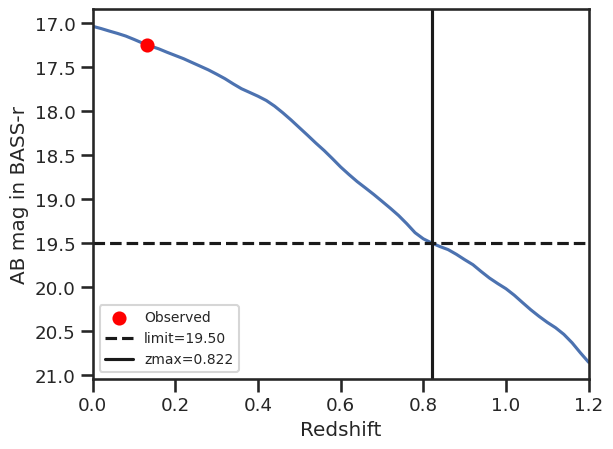

In [11]:
fig, ax = plt.subplots()
ax.plot(zgrid, mag_zgrid)
ax.scatter(redshift, -2.5 * np.log10(obsmaggies_select), marker='o', s=75, 
           color='red', label='Observed', zorder=2)
ax.axhline(y=mag_faint, color='k', ls='--', label=f'limit={mag_faint:.2f}')
ax.axvline(x=zmax, color='k', ls='-', label=f'zmax={zmax:.3f}')
ax.invert_yaxis()
ax.margins(x=0)
ax.set_xlabel('Redshift')
ax.set_ylabel(f'AB mag in {select_filter.name}');
ax.legend(fontsize=10, loc='lower left')

#### Compute Vmax (normalized to 14,000 deg2 survey area).

In [12]:
#h = 0.6766
h = 1.
omega_survey = 14000. # angular survey area [deg^2]
omega_sky = (4. * np.pi) * (180. / np.pi)**2 # [deg^2]
Vmax = (4. * np.pi / 3) * (omega_survey / omega_sky) * (cosmo.comoving_radial_distance(zmax)**3 - # [ (Mpc/h)^3 ]
                                                        cosmo.comoving_radial_distance(zmin)**3)
print(f'Vmax = {(Vmax * 1. / (1e3 * h)**3):,.2f} (Gpc / h)^3')

Vmax = 11.00 (Gpc / h)^3
